In [1]:
import os
import glob
import json
import shutil
import h5py
import sys
import time
from IPython.display import display

import torch

sys.path.insert(0, '..')
from corr_methods import load_representations

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
plt.style.use('seaborn-darkgrid')
fpath = '/raj-learn/envs/contextual_repr_analysis/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf'
prop = font_manager.FontProperties(fname=fpath)
rcParams['font.family'] = prop.get_name()
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.unicode_minus'] = False

### Parse PTB POS data

Get POS labels from PennTreebank file

In [3]:
pos_file = '/raj-learn/data/probing_task_data/pos/wsj.train.conllx'
pos_file = open(pos_file, 'r').read()

In [4]:
%%time
FIELDS = ["id", "form", "lemma", "coarse_pos", "pos"]

token_idx_to_label = {}
sentences = []
for sentence in pos_file.split('\n\n'):
    annotated_sentence = []
    
    lines = [line for line in sentence.split("\n")
             if line and not line.strip().startswith("#")]
    
    sentence = []
    labels = []
    for line_idx, line in enumerate(lines):
        # annotated_token = dict(zip(FIELDS, line.split("\t")))
        # annotated_sentence.append(annotated_token)
        tok_id, word, _, coarse_pos, pos, _, _, deprel = line.split('\t')
        sentence.append(word)
        labels.append((coarse_pos, pos, deprel))
    sentence = ' '.join(sentence)
    sentences.append(sentence)
    for (i, tok_label) in enumerate(labels):
        token_idx_to_label[(sentence, i)] = tok_label
sentences = set(sentences)

CPU times: user 1.61 s, sys: 127 ms, total: 1.74 s
Wall time: 1.74 s


### Load precomputed reps for PTB POS tokens

Load reps, for sentences that are in the sentences we loaded labels for (i.e., test set)

In [5]:
# Set arguments to load reps
reps_dir = '/raj-learn/data/precomputed_reps'
rep_fname_l = sorted(glob.glob(f'{reps_dir}/LTH*/pos_wsj_sentences.hdf5'))
rep_fname_l = [rep_fname_l[0], rep_fname_l[-1]]
layerspec_l = [5 for model in rep_fname_l]
device = 'cuda'
rep_fname_l

['/raj-learn/data/precomputed_reps/LTH0/pos_wsj_sentences.hdf5',
 '/raj-learn/data/precomputed_reps/LTH8/pos_wsj_sentences.hdf5']

In [13]:
import torch 
from tqdm import tqdm
from itertools import product as p
import json
import numpy as np
import h5py
from os.path import basename, dirname
import pickle
from var import fname2mname

def load_representations(representation_fname_l, sentence_set, limit=None,
                         layerspec_l=None, first_half_only_l=False,
                         second_half_only_l=False):
    # Main loop
    representations_d = {}
    token_idxs_d = {}
    for loop_var in tqdm(zip(representation_fname_l, layerspec_l)):
        fname, layerspec = loop_var

        # Set `activations_h5`, `sentence_d`, `indices`
        activations_h5 = h5py.File(fname, 'r')
        sentence_to_index = json.loads(activations_h5['sentence_to_index'][0])
        index_to_sentence = {} # TO DO: Make this more elegant?
        for k, v in sentence_to_index.items():
            index_to_sentence[v] = k
#         indices = sorted(list(index_to_sentence.keys()))[-10000:]
        indices = list(index_to_sentence.keys())[:10000]

        # Set `num_layers`, `num_neurons`, `layers`
        s = activations_h5[indices[0]].shape
        num_layers = 1 if len(s)==2 else s[0]
        num_neurons = s[-1]
        layer = layerspec

        # Set `num_neurons_d`, `representations_d`
        # Create `representations_l`
        representations_l = []
        token_idxs_l = []
        word_count = 0
        for sentence_ix in indices: 
            if index_to_sentence[sentence_ix] not in sentence_set:
                continue
            # Set `dim`, `n_word`, update `word_count`
            shape = activations_h5[sentence_ix].shape
            dim = len(shape)
            n_word = shape[1]
            word_count += n_word

            # Create `activations`
            activations = torch.FloatTensor(
                activations_h5[sentence_ix][layer]
            )

            representations_l.append(activations)
            
            # Get sentence, token idx
            token_idxs_l.extend([(index_to_sentence[sentence_ix], token_idx) for token_idx in range(n_word)])

        # Main update
        mname = fname2mname(fname).split('-')[0]
        network = "{mname}_{layer}".format(mname=mname, 
                                           layer=layer)
        representations_d[network] = torch.cat(representations_l)
        token_idxs_d[network] = token_idxs_l
    
    return representations_d, token_idxs_d

In [11]:
%%time
representations_d, token_idxs_d, = load_representations(rep_fname_l,
                                                        sentence_set=sentences, 
                                                        layerspec_l=layerspec_l
                                                        )
num_neurons_d = {key : 1024 for key in representations_d}

2it [16:44, 502.04s/it]

CPU times: user 1min 18s, sys: 3.51 s, total: 1min 22s
Wall time: 16min 44s


In [12]:
%%time
np.savez('/raj-learn/data/precomputed_reps/wordgroupanalysis/180k_pos.npz',
         rep_lth0 = representations_d['LTH0_5'],
         rep_lth8 = representations_d['LTH8_5'],
         tok_lth0 = token_idxs_d['LTH0_5'],
         tok_lth8 = token_idxs_d['LTH8_5'],
        )

CPU times: user 24.3 s, sys: 4.67 s, total: 29 s
Wall time: 2min 30s


### Load precomputed PTB POS tokens from npz file

In [ ]:
%%time
pos_data = np.load('/raj-learn/data/precomputed_reps/wordgroupanalysis/180k_pos.npz')
representations_d = {}
token_idxs_d = {}
representations_d['LTH0_5'] = pos_data['rep_lth0']
representations_d['LTH8_5'] = pos_data['rep_lth8']
token_idxs_d['LTH0_5'] = pos_data['tok_lth0']
token_idxs_d['LTH8_5'] = pos_data['tok_lth8']

In [210]:
print(representations_d['LTH0_5'].shape)
print(token_idxs_d['LTH0_5'][0])

torch.Size([180756, 1024])
('# 200 million of undated variable-rate notes priced at par via Merill Lynch International Ltd .', 0)


### Compute SVCCA / linCKA scores for each POS group

#### Get list of token idxs per label

In [34]:
label_set1 = []
label_set2 = []
for key in token_idx_to_label:
    label_set1.append(token_idx_to_label[key][1])
    label_set2.append(token_idx_to_label[key][2])
label_set1 = set(label_set1)
label_set2 = set(label_set2)
label_set = label_set1.union(label_set2)

token_idxs_per_label = {label : [] for label in label_set}
for (i, token_idx) in enumerate(token_idxs_d['LTH0_5']):
    tok_label = token_idx_to_label[token_idx]
    coarse_pos, pos, deprel = tok_label
    token_idxs_per_label[pos].append(i)
#     token_idxs_per_label[coarse_pos].append(i)
    token_idxs_per_label[deprel].append(i)

In [35]:
%%time
import corr_methods

label_similarities = []
for subset_label in label_set:
    if len(token_idxs_per_label[subset_label]) <= 1:
        continue
    subset_representations_d = {}
    for model in representations_d:
        subset_representations_d[model] = representations_d[model][token_idxs_per_label[subset_label]]
    n_tokens = subset_representations_d[model].shape[0]
    if n_tokens < 100:
        continue
    
    lincka = corr_methods.LinCKA(num_neurons_d, subset_representations_d.copy(), device)
    lincka.compute_correlations()
    sim = lincka.similarities['LTH0_5']['LTH8_5']
    label_similarities.append((subset_label, n_tokens, round(sim, 4)))

label_similarities = sorted(label_similarities, key=lambda x:x[2])
label_similarities_set1 = []
label_similarities_set2 = []
for result in label_similarities:
    if result[0] in label_set1:
        label_similarities_set1.append(result)
    if result[0] in label_set2:
        label_similarities_set2.append(result)
display(label_similarities_set1)
display(label_similarities_set2)
        
label_sim_dict = {}
for (subset_label, n_tokens, sim) in label_similarities:
    label_sim_dict[subset_label] = (sim, n_tokens)

[('POS', 1654, 0.7922),
 ('$', 1281, 0.829),
 ('.', 7654, 0.8447),
 ('RP', 522, 0.8551),
 ('NNP', 16957, 0.8618),
 ('``', 105, 0.8646),
 ('PRP$', 1603, 0.8647),
 ('NN', 25709, 0.8666),
 ('EX', 129, 0.8706),
 ('NNS', 12617, 0.8756),
 ('JJ', 12286, 0.8762),
 ('VBN', 4008, 0.8801),
 ('VB', 5149, 0.8814),
 ('WDT', 782, 0.8829),
 ('DT', 15681, 0.8847),
 ('VBG', 3124, 0.8849),
 ('IN', 19353, 0.8897),
 ('VBZ', 3648, 0.8983),
 ('NNPS', 557, 0.9006),
 ('VBP', 2552, 0.9101),
 ('RB', 5938, 0.9124),
 (',', 8909, 0.9148),
 ('TO', 4361, 0.9235),
 ('PRP', 2437, 0.9244),
 ('MD', 1925, 0.9304),
 ('VBD', 5522, 0.9311),
 ('JJR', 689, 0.9326),
 ('WRB', 379, 0.9408),
 ('CD', 6461, 0.9485),
 ('WP', 381, 0.9519),
 ('RBR', 400, 0.9573),
 (':', 1122, 0.9604),
 ('-LRB-', 259, 0.9664),
 ('JJS', 364, 0.9685),
 ('-RRB-', 250, 0.9744),
 ('CC', 5683, 0.9777)]

[('OBJ', 7048, 0.8541),
 ('PMOD', 18676, 0.8605),
 ('VC', 5555, 0.8767),
 ('PRD', 2241, 0.8775),
 ('SBAR', 3715, 0.8808),
 ('NMOD', 68797, 0.8814),
 ('SUB', 12668, 0.8923),
 ('P', 19609, 0.895),
 ('DEP', 860, 0.9067),
 ('VMOD', 27160, 0.9074),
 ('ROOT', 7750, 0.9269),
 ('AMOD', 6677, 0.9457)]

CPU times: user 17.1 s, sys: 12.9 s, total: 30 s
Wall time: 3.88 s


### Compute similarities for various token frequencies

In [2]:
%%time
# fname = '/raj-learn/data/precomputed_reps/LTH0/pos_wsj_sentences.hdf5'
# fname = '/raj-learn/data/precomputed_reps/LTH0/semantic_tagging.hdf5'
fname = '/raj-learn/data/precomputed_reps/LTH0/adposition_supersense_sentences.hdf5'
activations_h5 = h5py.File(fname, 'r')
sentence_to_index = json.loads(activations_h5['sentence_to_index'][0])
sentences = sentence_to_index.keys()

CPU times: user 5.98 ms, sys: 11.9 ms, total: 17.9 ms
Wall time: 1.21 s


In [3]:
%%time
token_counts = {}
for sentence in sentences:
    tokens = sentence.split(' ')
    for tok in tokens:
        if tok not in token_counts:
            token_counts[tok] = 0
        token_counts[tok] += 1
token_counts = list(token_counts.items())
token_counts = sorted(token_counts, key=lambda x: -x[1])
print("# tokens = %d" % len(token_counts))
display(token_counts[:10])
# display(token_counts[10000:10010])

# tokens = 5871


[('.', 1794),
 ('the', 1467),
 ('and', 1272),
 (',', 1183),
 ('to', 1122),
 ('I', 1112),
 ('a', 882),
 ('of', 571),
 ('in', 535),
 ('for', 480)]

CPU times: user 71.6 ms, sys: 0 ns, total: 71.6 ms
Wall time: 69.2 ms


In [251]:
cumsums = [token_counts[0][1]]
for i in range(1, len(token_counts)):
    cumsums.append(cumsums[i-1] + token_counts[i][1])
cumsums = np.array(cumsums)
cumsums = cumsums / cumsums[-1]
frequency_rank_boundaries = [0, 5, 25, 50, 100, 250, 500, 1000, 2500, 5870]#, 10000, 39035]
# for rk in frequency_rank_boundaries: print('%.3f' % cumsums[rk])

In [252]:
%%time
token_to_freqbin = {}
for i in range(len(frequency_rank_boundaries) - 1):
    freqbin = (frequency_rank_boundaries[i], frequency_rank_boundaries[i+1])
    for j in range(freqbin[0], freqbin[1]):
        token_to_freqbin[token_counts[j][0]] = freqbin

freqbin_to_tokenidxs = {}
i = 0
while i < len(token_idxs_d['LTH0_5']):
    sent, _ = token_idxs_d['LTH0_5'][i]
    sent = sent.split(' ')
    for (j, tok) in enumerate(sent):
        try:
            freqbin = token_to_freqbin[tok]
        except KeyError:
#             print(tok)
            continue
        if freqbin not in freqbin_to_tokenidxs:
            freqbin_to_tokenidxs[freqbin] = []
        freqbin_to_tokenidxs[freqbin].append(i+j)
    i += len(sent)

CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 137 ms


In [253]:
%%time
for (freqbin, tokenidxs) in sorted(freqbin_to_tokenidxs.items()):
    print(freqbin, "n = %d" % len(tokenidxs))
    subset_representations_d = {}
    for model in representations_d:
        subset_representations_d[model] = representations_d[model][tokenidxs]
    n_tokens = subset_representations_d[model].shape[0]
    lincka = corr_methods.LinCKA(num_neurons_d, subset_representations_d, device)
    lincka.compute_correlations()
    sim = lincka.similarities['LTH0_5']['LTH8_5']
    print("Similarity: %.3f\n" % sim)

(0, 5) n = 32359
Similarity: 0.874

(5, 25) n = 21352
Similarity: 0.896

(25, 50) n = 7371
Similarity: 0.920

(50, 100) n = 10546
Similarity: 0.914

(100, 250) n = 13665
Similarity: 0.945

(250, 500) n = 10998
Similarity: 0.951

(500, 1000) n = 9207
Similarity: 0.896

(1000, 2500) n = 12770
Similarity: 0.875

(2500, 5870) n = 11294
Similarity: 0.875

CPU times: user 6.4 s, sys: 4.39 s, total: 10.8 s
Wall time: 1.4 s


In [237]:
%%time
for (freqbin, tokenidxs) in sorted(freqbin_to_tokenidxs.items()):
    print(freqbin, "n = %d" % len(tokenidxs))
    subset_representations_d = {}
    for model in representations_d:
        subset_representations_d[model] = representations_d[model][tokenidxs]
    n_tokens = subset_representations_d[model].shape[0]
    lincka = corr_methods.LinCKA(num_neurons_d, subset_representations_d, device)
    lincka.compute_correlations()
    sim = lincka.similarities['LTH0_5']['LTH8_5']
    print("Similarity: %.3f\n" % sim)

(0, 5) n = 33816
Similarity: 0.863

(5, 25) n = 26425
Similarity: 0.931

(25, 50) n = 12979
Similarity: 0.947

(50, 100) n = 12038
Similarity: 0.921

(100, 250) n = 15316
Similarity: 0.895

(250, 500) n = 13509
Similarity: 0.875

(500, 1000) n = 14497
Similarity: 0.874

(1000, 2500) n = 18840
Similarity: 0.865

(2500, 5000) n = 12227
Similarity: 0.865

(5000, 10000) n = 9660
Similarity: 0.875

(10000, 42831) n = 11449
Similarity: 0.891

CPU times: user 8 s, sys: 5.02 s, total: 13 s
Wall time: 1.62 s


In [247]:
%%time
for (freqbin, tokenidxs) in sorted(freqbin_to_tokenidxs.items()):
    print(freqbin, "n = %d" % len(tokenidxs))
    subset_representations_d = {}
    for model in representations_d:
        subset_representations_d[model] = representations_d[model][tokenidxs]
    n_tokens = subset_representations_d[model].shape[0]
    lincka = corr_methods.LinCKA(num_neurons_d, subset_representations_d, device)
    lincka.compute_correlations()
    sim = lincka.similarities['LTH0_5']['LTH8_5']
    print("Similarity: %.3f\n" % sim)

(0, 5) n = 32442
Similarity: 0.867

(5, 25) n = 25404
Similarity: 0.904

(25, 50) n = 9009
Similarity: 0.932

(50, 100) n = 8523
Similarity: 0.964

(100, 250) n = 12996
Similarity: 0.948

(250, 500) n = 9899
Similarity: 0.905

(500, 1000) n = 11916
Similarity: 0.888

(1000, 2500) n = 21997
Similarity: 0.876

(2500, 5000) n = 13087
Similarity: 0.863

(5000, 10000) n = 11585
Similarity: 0.871

(10000, 39035) n = 12013
Similarity: 0.865

CPU times: user 6.99 s, sys: 10.1 s, total: 17.1 s
Wall time: 2.18 s


### Compute similarities for various semantic tags

In [9]:
%%time
semtag_file = '/raj-learn/data/probing_task_data/semantic_tagging/semtag_train.conll'
semtag_file = open(semtag_file, 'r').read()

CPU times: user 183 µs, sys: 29.2 ms, total: 29.4 ms
Wall time: 516 ms


In [10]:
%%time
token_idx_to_label = {}
sentences = []
for sentence in semtag_file.split('\n\n'):
    annotated_sentence = []
    
    lines = [line for line in sentence.split("\n")
             if line and not line.strip().startswith("#")]
    
    sentence = []
    labels = []
    for line_idx, line in enumerate(lines):
        word, label = line.split('\t')
        sentence.append(word)
        labels.append(label)
    sentence = ' '.join(sentence)
    sentences.append(sentence)
    for (i, tok_label) in enumerate(labels):
        token_idx_to_label[(sentence, i)] = tok_label
sentences = set(sentences)

CPU times: user 1.52 s, sys: 0 ns, total: 1.52 s
Wall time: 1.52 s


In [11]:
# Set arguments to load reps
limit = 100000
reps_dir = '/raj-learn/data/precomputed_reps'
rep_fname_l = sorted(glob.glob(f'{reps_dir}/LTH*/semantic_tagging.hdf5'))
rep_fname_l = [rep_fname_l[0], rep_fname_l[-1]]
layerspec_l = [5 for model in rep_fname_l]
device = 'cuda'
rep_fname_l

['/raj-learn/data/precomputed_reps/LTH0/semantic_tagging.hdf5',
 '/raj-learn/data/precomputed_reps/LTH8/semantic_tagging.hdf5']

In [14]:
%%time
representations_d, token_idxs_d = load_representations(rep_fname_l,
                                                       sentence_set=sentences,
                                                       layerspec_l=layerspec_l
                                                    )
num_neurons_d = {key : 1024 for key in representations_d}

2it [34:12, 1026.30s/it]

CPU times: user 1min 6s, sys: 2.49 s, total: 1min 9s
Wall time: 34min 12s


In [15]:
print(representations_d['LTH0_5'].shape)
print(token_idxs_d['LTH0_5'][0])

torch.Size([138463, 1024])
('" A kind act , " replied the Ostrich , " is its own reward ; I have eaten the keys . "', 0)


In [16]:
%%time
np.savez('/raj-learn/data/precomputed_reps/wordgroupanalysis/138k_semtag.npz',
         rep_lth0 = representations_d['LTH0_5'],
         rep_lth8 = representations_d['LTH8_5'],
         tok_lth0 = token_idxs_d['LTH0_5'],
         tok_lth8 = token_idxs_d['LTH8_5'],
        )

CPU times: user 18.7 s, sys: 4.18 s, total: 22.9 s
Wall time: 1min 20s


In [ ]:
%%time
import numpy as np
# data = np.load('/raj-learn/data/precomputed_reps/wordgroupanalysis/138k_semtag.npz')
# data = np.load('/raj-learn/data/precomputed_reps/wordgroupanalysis/180k_pos.npz')
representations_d = {}
token_idxs_d = {}
representations_d['LTH0_5'] = torch.FloatTensor(data['rep_lth0'])
representations_d['LTH8_5'] = torch.FloatTensor(data['rep_lth8'])
token_idxs_d['LTH0_5'] = data['tok_lth0']
token_idxs_d['LTH8_5'] = data['tok_lth8']
token_idxs_d['LTH0_5'] = [(x[0], int(x[1])) for x in token_idxs_d['LTH0_5']]
token_idxs_d['LTH8_5'] = [(x[0], int(x[1])) for x in token_idxs_d['LTH8_5']]
num_neurons_d = {key : 1024 for key in representations_d}
device = 'cuda'

#### Get indices of tokens for each label

In [17]:
label_set = []
for key in token_idx_to_label:
    label_set.append(token_idx_to_label[key])
label_set = set(label_set)

token_idxs_per_label = {label : [] for label in label_set}
for (i, token_idx) in enumerate(token_idxs_d['LTH0_5']):
    tok_label = token_idx_to_label[token_idx]
    if tok_label not in token_idxs_per_label:
        token_idxs_per_label[tok_label] = []
    token_idxs_per_label[tok_label].append(i)

#### Compute linCKAs for each set of tokens

In [18]:
%%time
import corr_methods

label_similarities = []
for subset_label in label_set:
    if len(token_idxs_per_label[subset_label]) <= 1:
        continue
    subset_representations_d = {}
    for model in representations_d:
        subset_representations_d[model] = representations_d[model][token_idxs_per_label[subset_label]]
    n_tokens = subset_representations_d[model].shape[0]
    if n_tokens < 100:
        continue
    
    lincka = corr_methods.LinCKA(num_neurons_d, subset_representations_d.copy(), device)
    lincka.compute_correlations()
    sim = lincka.similarities['LTH0_5']['LTH8_5']
    label_similarities.append((subset_label, n_tokens, sim))

label_similarities = sorted(label_similarities, key=lambda x:x[2])
label_sim_dict = {}
display(label_similarities)
for (subset_label, n_tokens, sim) in label_similarities:
#     print(f'Label {subset_label}, n = {n_tokens}')
#     print('Similarity = %.3f\n' % sim)
    label_sim_dict[subset_label] = (sim, n_tokens)

[('UOM', 105, 0.8075279187571034),
 ('ENG', 427, 0.8197983196415826),
 ('ENT', 1529, 0.8372658946253033),
 ('EPG', 123, 0.8421216925106709),
 ('EPT', 155, 0.8421446460387945),
 ('ETV', 307, 0.8430546327155997),
 ('DEF', 7093, 0.8504817101012028),
 ('CON', 25792, 0.8721803195445574),
 ('NOT', 572, 0.8735297271320126),
 ('ORG', 3717, 0.8810574199180646),
 ('EXG', 2374, 0.8866627265298462),
 ('REL', 20912, 0.8883963484356627),
 ('DIS', 5537, 0.8922934989485953),
 ('PER', 3287, 0.8951815956544568),
 ('YOC', 577, 0.8954821285507731),
 ('GPE', 2110, 0.9021111277725286),
 ('UNK', 767, 0.9021570329734455),
 ('FUT', 564, 0.9038246202766937),
 ('COO', 970, 0.9052793787375617),
 ('MOY', 355, 0.9056129150924742),
 ('BUT', 168, 0.9056752569073078),
 ('POS', 238, 0.9091452569817361),
 ('LOC', 4939, 0.9091963200839869),
 ('IST', 10309, 0.9144683806174062),
 ('TIM', 1153, 0.9170575077505542),
 ('AND', 2194, 0.9238585463255824),
 ('SUB', 3479, 0.9244588964611107),
 ('EPS', 794, 0.9247476640343862),
 ('

CPU times: user 16.5 s, sys: 4.12 s, total: 20.7 s
Wall time: 1min 2s


In [19]:
%%time
examples_per_tag = {'TOP' : [],
                    'MOR' : [],
                    'INT' : [],
                    'PRX' : [],
                    'NOW' : [],
                    'QUE' : [],
                    'APP' : [],
                    'ENG' : [],
                    'ENT' : [],
                    'EPT' : [],
                    'ETV' : [],
                    'DEF' : [],
                    'CON' : [],
                   }
# tags_of_interest = ['RP']#, 'JJS']
# tags_of_interest = ['POS',
#                     '$',
#                     'JJS',
#                     'CC',
#                     'POS',
#                     'POS',
#                    ]
# examples_per_tag = {tag : [] for tag in tags_of_interest}
for (key, value) in token_idx_to_label.items():
    sent, tok_idx = key
    sent = sent.split(' ')
    sent[tok_idx] += '*'
    low = max(tok_idx - 2, 0)
    high = min(tok_idx + 2, len(sent))
    context = sent[low : high]
    if value in examples_per_tag:
        examples_per_tag[value].append(context)
    try:
        if value[1] in examples_per_tag:
            examples_per_tag[value[1]].append(context)
        if value[2] in examples_per_tag:
            examples_per_tag[value[2]].append(context)
    except KeyError:
        continue

for key in examples_per_tag:
    sim, n_tokens = label_sim_dict[key]
    print(key, '%.3f' % sim, n_tokens)
    print(examples_per_tag[key][n_tokens // 3 : n_tokens // 3 + 5])
    print()

TOP 0.982 542
[['killed', 'at', 'least*', 'three'], ['Baghdad', ',', 'at*', 'least'], ['has', 'the', 'largest*', 'and'], ['police', 'say', 'at*', 'least'], ['where', 'the', 'largest*', 'demonstration']]

MOR 0.975 380
[['to', 'a', 'more*', 'industrialized'], ['has', 'killed', 'more*', 'than'], ['killed', 'more', 'than*', '200'], [',', 'as', 'lower*', 'world'], ['of', 'three', 'more*', 'American']]

INT 0.966 445
[['Malta', 'produces', 'only*', 'about'], ['produces', 'only', 'about*', '20'], ['has', 'produced', 'steadily*', 'improving'], ['Israel', "'s", 'recently*', 'concluded'], ['be', 'the', 'most*', 'senior']]

PRX 0.963 192
[['election', 'victory', 'this*', 'week'], ['made', 'public', 'this*', 'week'], ['Earlier', 'this*', 'week'], ['expected', 'later', 'this*', 'week'], ['Maoist', 'rebels', 'this*', 'past']]

NOW 0.960 3338
[['Atwood', ',', 'says*', 'more'], ['Interior', 'Ministry', 'says*', 'roadside'], ['Ms.', 'Rice', 'is*', 'the'], ['challenges', 'that', 'include*', 'the'], ['t

#### Get indices of specific tokens

In [231]:
# tokens_of_interest = ['$', '.', ',', '\'s']
# tokens_of_interest = ['is', 'are', 'was', 'were']
# tokens_of_interest = ['to', 'from', 'with', 'for']
# tokens_of_interest = ['but', 'their', 'been', 'most']
# tokens_of_interest = ['who', 'which', 'what']
tokens_of_interest = ['most', 'or', '\'s', '.']
tag_index_sets = {tok : [] for tok in tokens_of_interest}
i = 0
while i < len(token_idxs_d['LTH0_5']):
    sent, _ = token_idxs_d['LTH0_5'][i]
    sent = sent.split(' ')
    for (j, tok) in enumerate(sent):
        if tok in tag_index_sets:
            tag_index_sets[tok].append(i+j)
    i += len(sent)
for tok in tag_index_sets:
    print(tok, len(tag_index_sets[tok]))

most 161
or 404
's 1635
. 7577


#### Get indices of specific groups

In [236]:
groups_of_interest = ['.', 'JJS', 'RP', 'PRP$']

tag_index_sets = {grp : [] for grp in groups_of_interest}
for (i, tok_idx) in enumerate(token_idxs_d['LTH0_5']):
    coarse, pos, deprel = token_idx_to_label[tok_idx]
    if pos in groups_of_interest:
        tag_index_sets[pos].append(i)
for grp in tag_index_sets:
    print(grp, len(tag_index_sets[grp]))

. 7654
JJS 364
RP 522
PRP$ 1603


### PCA / UMAP

In [45]:
all_reps = torch.cat([representations_d['LTH0_5'],
                      representations_d['LTH8_5']
                      ], dim=0)

In [48]:
%%time
U, S, V = torch.svd(all_reps)

CPU times: user 2min 52s, sys: 36.1 s, total: 3min 28s
Wall time: 31.2 s


In [49]:
%%time
n_pcs = 50
reps_pca = torch.matmul(all_reps,  V[:, :n_pcs])

CPU times: user 2.38 s, sys: 7.36 ms, total: 2.39 s
Wall time: 279 ms


#### We can fit this UMAP once and use it many times

In [167]:
%%time
import umap

use_for_emb = 50000
total_tokens = len(representations_d['LTH0_5'])
x = torch.cat([reps_pca[ : use_for_emb],
               reps_pca[total_tokens : total_tokens + use_for_emb]])
umap = umap.UMAP(n_neighbors=10,
                 min_dist=0.3,
                 metric='cosine')
umap.fit(x.data)

CPU times: user 39min 3s, sys: 38.1 s, total: 39min 41s
Wall time: 5min 27s


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.3, n_neighbors=10)

#### Apply our fit UMAP to indices of interest. keep track of labels for each index

torch.Size([19554, 50])


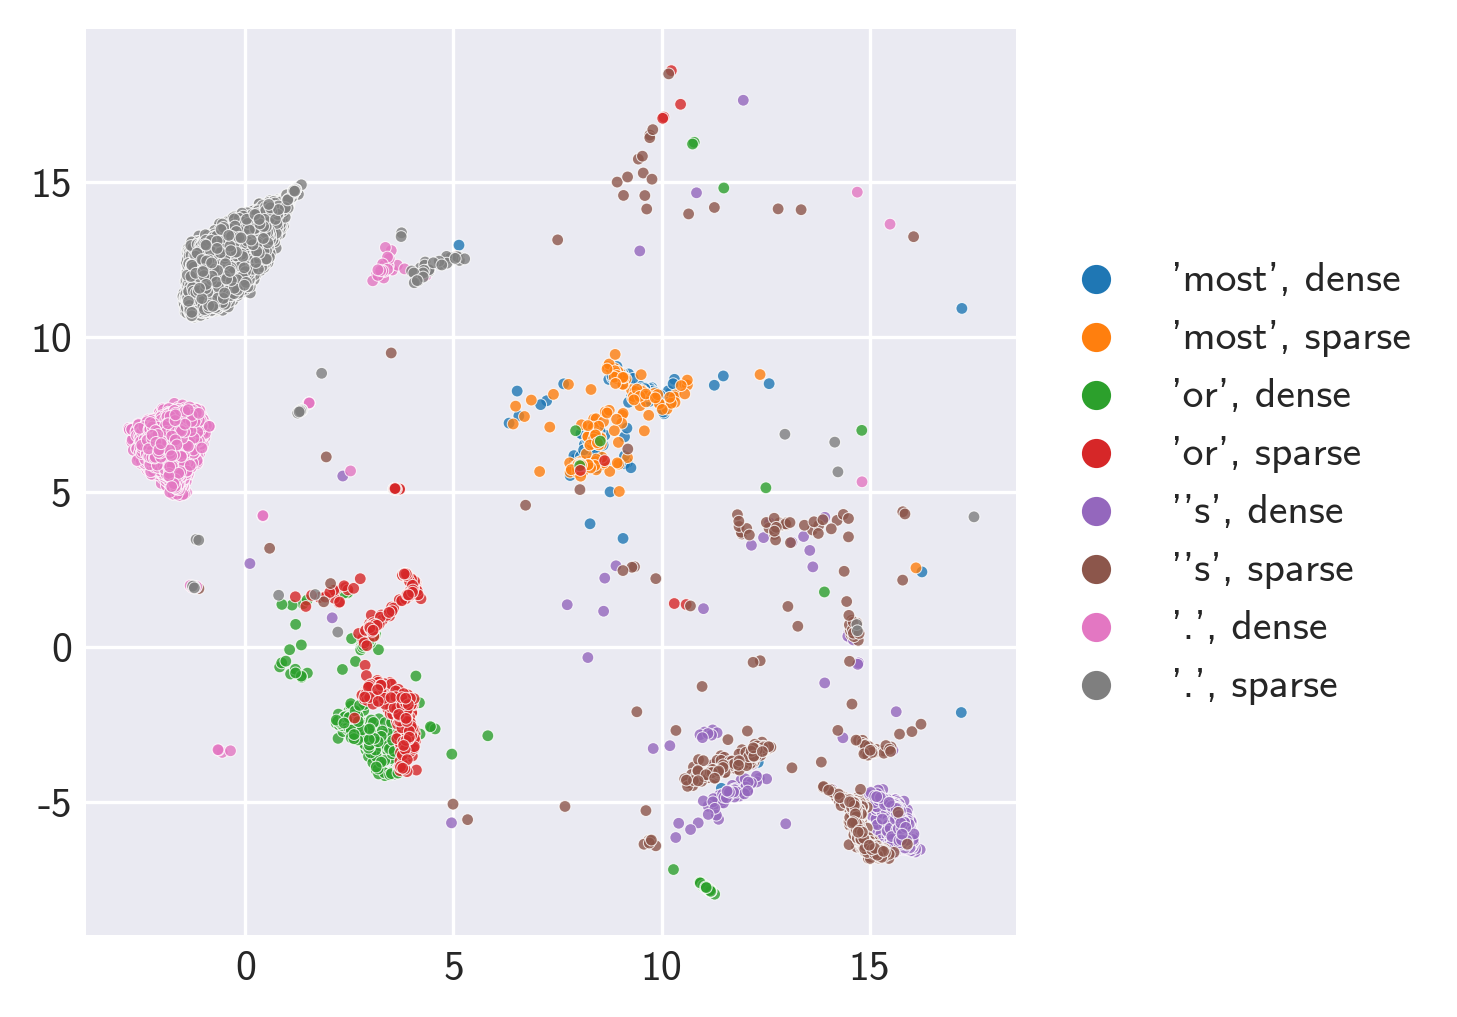

CPU times: user 52.1 s, sys: 639 ms, total: 52.7 s
Wall time: 11.1 s


In [232]:
%%time
point_labels = []
indices_of_interest = []
token_limit = 10000
for (grp, indices) in tag_index_sets.items():
    count = len(indices)
    if count > token_limit:
        indices = indices[:token_limit]
        count = token_limit
    # LTH0
#     lab_dense = f'{grp}, dense'
    lab_dense = f'\'{grp}\', dense'
    point_labels.extend([lab_dense]*count)
    indices_of_interest.extend(indices)
    # LTH8
#     lab_sparse = f'{grp}, sparse'
    lab_sparse = f'\'{grp}\', sparse'
    point_labels.extend([lab_sparse]*count)
    indices_of_interest.extend([idx + total_tokens for idx in indices])

reps_subset = reps_pca[indices_of_interest]
print(reps_subset.shape)
emb = umap.transform(reps_subset)

### PLOT ###

plt.figure(figsize=(4,4), dpi=300)

ax = sns.scatterplot(emb[:, 0], emb[:, 1], hue=point_labels,
                     s=8,
                     alpha=0.8,
                     linewidth=0.25
                    )
# ax.set_xlim([0, 10])
# ax.set_ylim([0, 5])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

torch.Size([8000, 50])


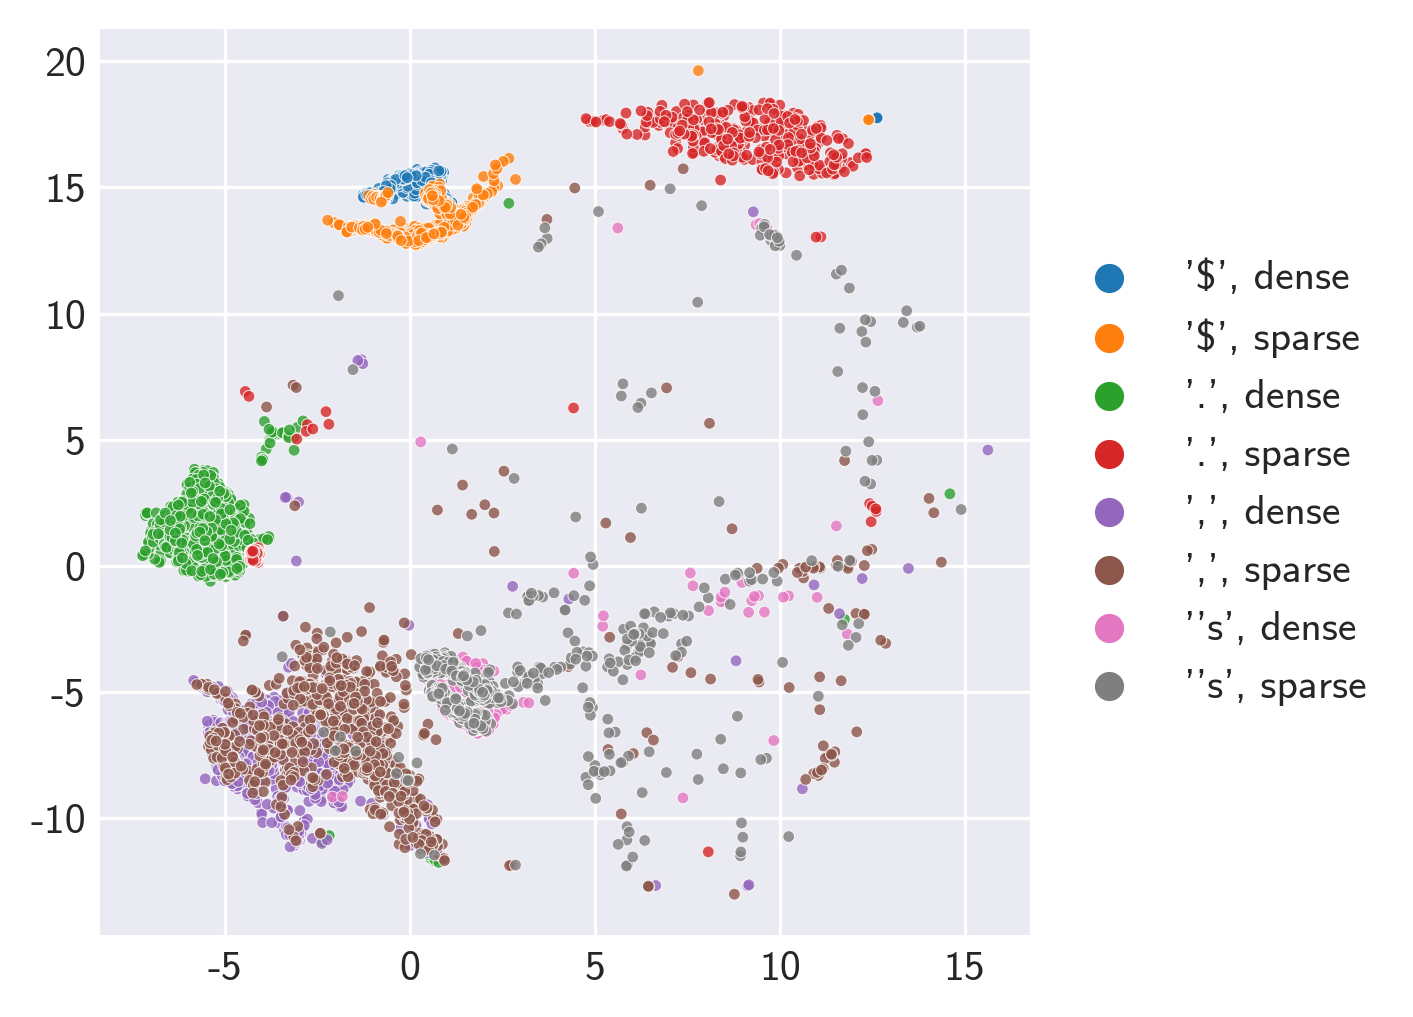

CPU times: user 58.6 s, sys: 625 ms, total: 59.2 s
Wall time: 9.65 s


In [166]:
%%time
point_labels = []
indices_of_interest = []
for (grp, indices) in tag_index_sets.items():
    count = len(indices)
#     if count > 1000:
#         indices = indices[:1000]
#         count = 1000
    # LTH0
#     lab_dense = f'{grp}, dense'
    lab_dense = f'\'{grp}\', dense'
    point_labels.extend([lab_dense]*count)
    indices_of_interest.extend(indices)
    # LTH8
#     lab_sparse = f'{grp}, sparse'
    lab_sparse = f'\'{grp}\', sparse'
    point_labels.extend([lab_sparse]*count)
    indices_of_interest.extend([idx + total_tokens for idx in indices])

reps_subset = reps_pca[indices_of_interest]
print(reps_subset.shape)
emb = umap.transform(reps_subset)

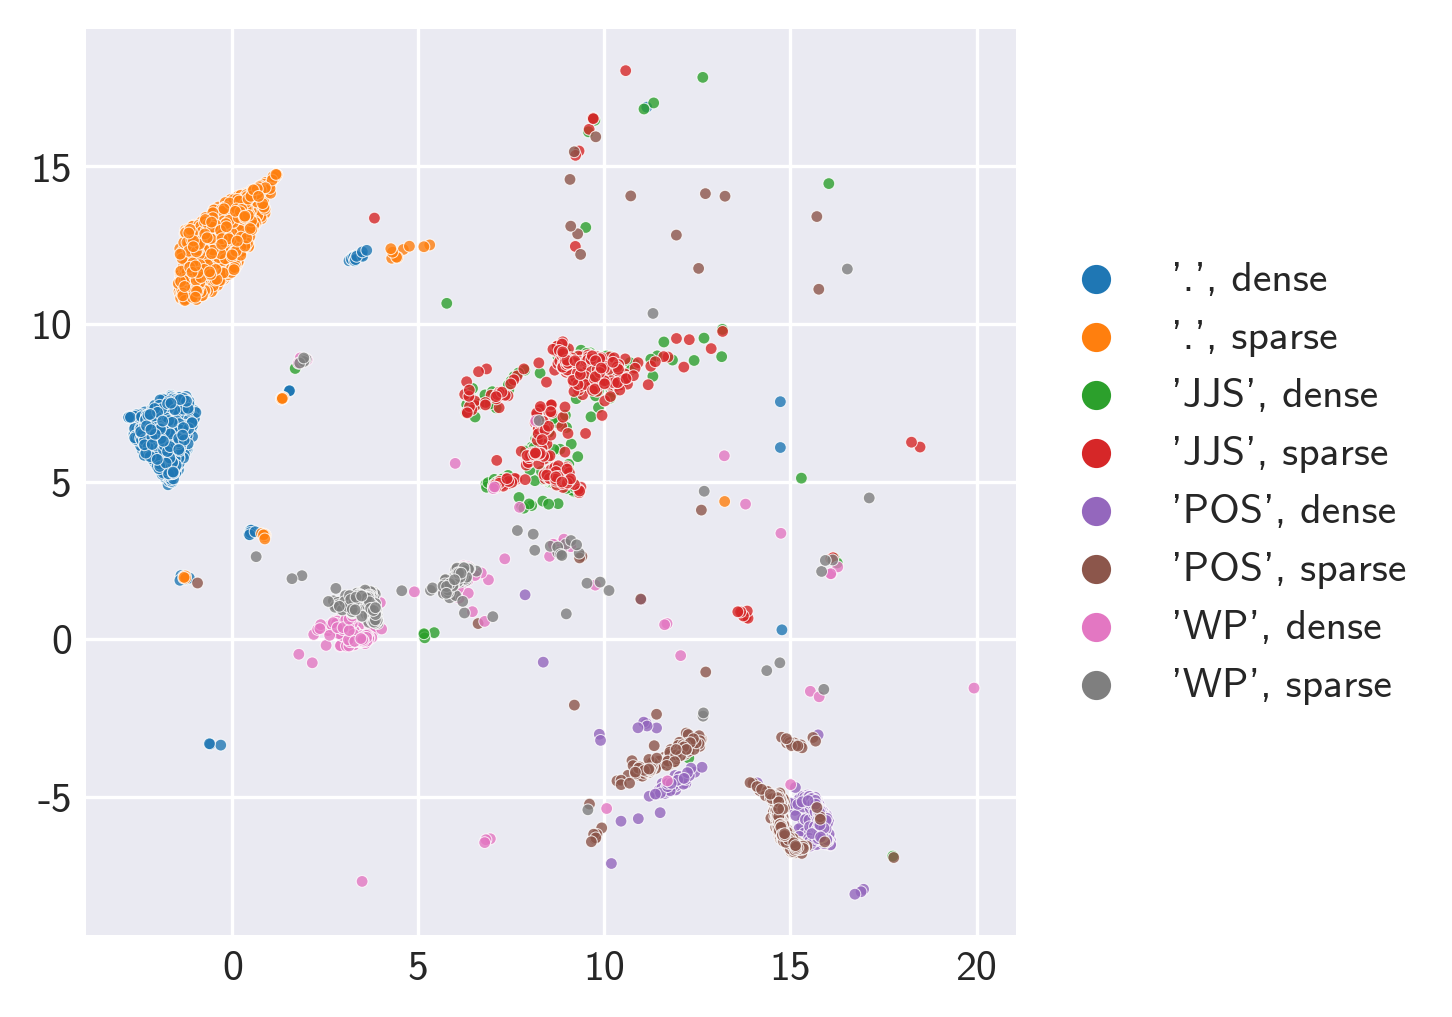

In [225]:
plt.figure(figsize=(4,4), dpi=300)

ax = sns.scatterplot(emb[:, 0], emb[:, 1], hue=point_labels,
                     s=8,
                     alpha=0.8,
                     linewidth=0.25
                    )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Try making separate UMAP plots for each category 
so we aren't confounded by differing variances of differing categories

., n_tokens = 7654
JJS, n_tokens = 364
RP, n_tokens = 522
PRP$, n_tokens = 1603


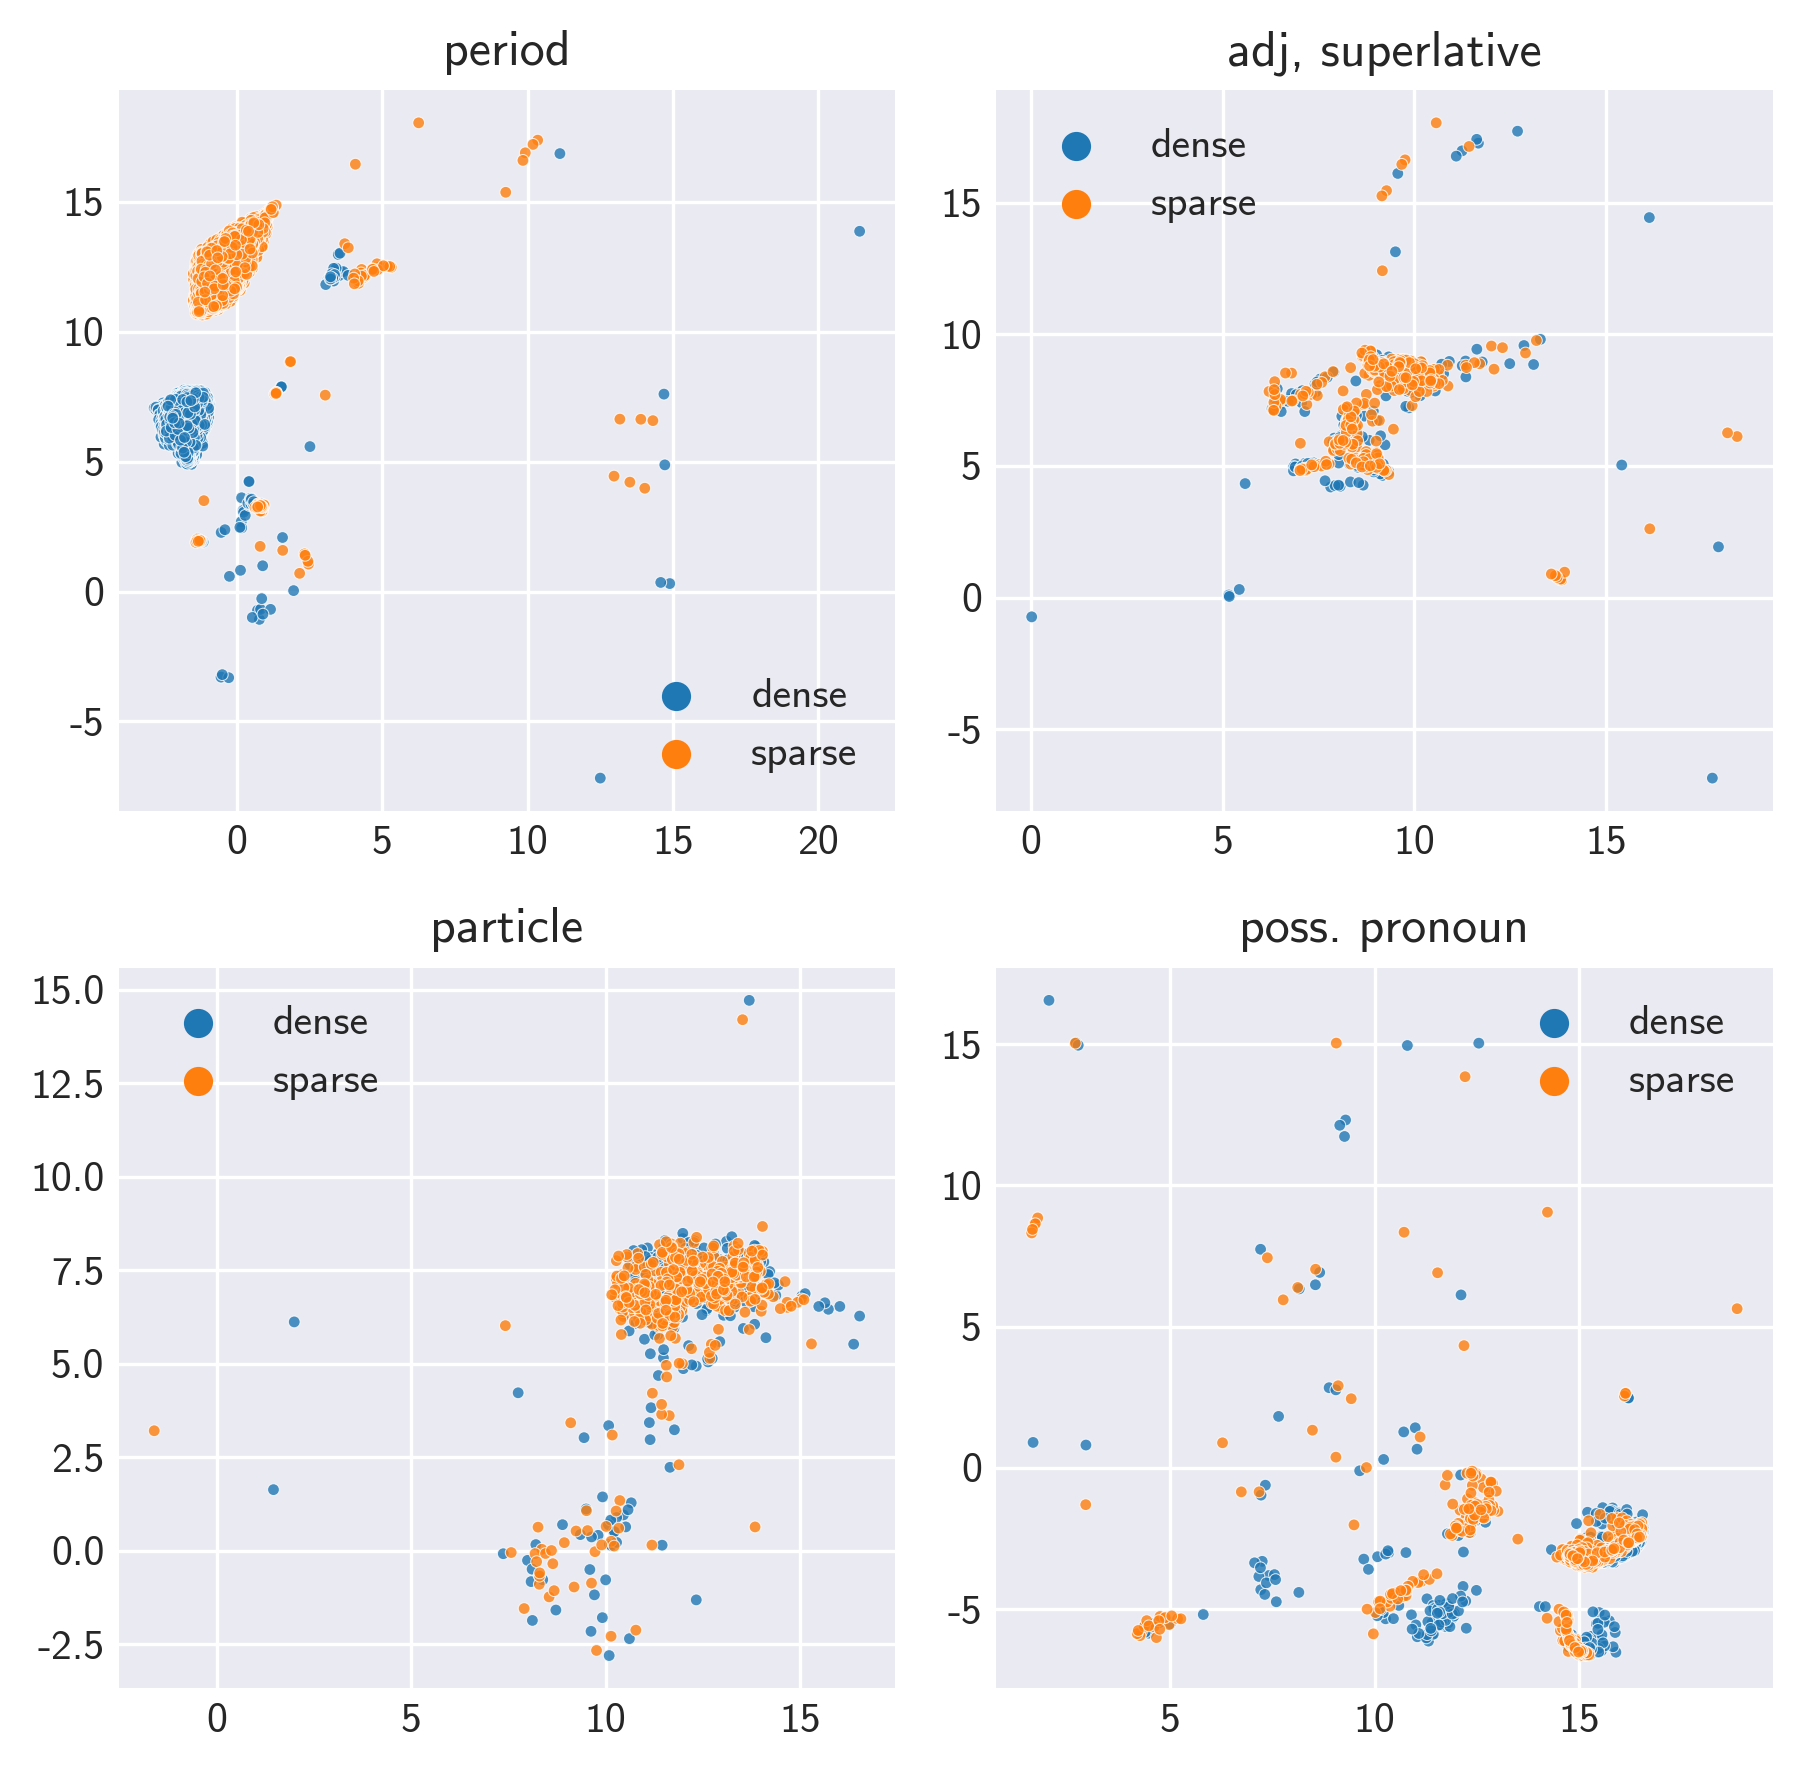

CPU times: user 1min 21s, sys: 2.04 s, total: 1min 23s
Wall time: 21.8 s


In [239]:
%%time
titles = ['period', 'adj, superlative', 'particle', 'poss. pronoun']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), dpi=300)
axs = np.array(axs).flatten()
i = 0
for (grp, indices) in tag_index_sets.items():
    count = len(indices)
    print(f'{grp}, n_tokens = {count}')
    point_labels = ['dense']*count + ['sparse']*count
    indices_of_interest = indices + [idx + total_tokens for idx in indices]
    
    reps_subset = reps_pca[indices_of_interest]
    emb = umap.transform(reps_subset)
    
    sns.scatterplot(emb[:, 0], emb[:, 1], hue=point_labels, s=8, alpha=0.8, linewidth=0.25, ax=axs[i])
    axs[i].set_title(titles[i])
    i += 1
plt.tight_layout()
plt.savefig('/raj-learn/lth-fairseq/analysis/figures/POS_UMAP.png')
plt.show()

., n_tokens = 7654
JJS, n_tokens = 364
RP, n_tokens = 522
PRP$, n_tokens = 1603


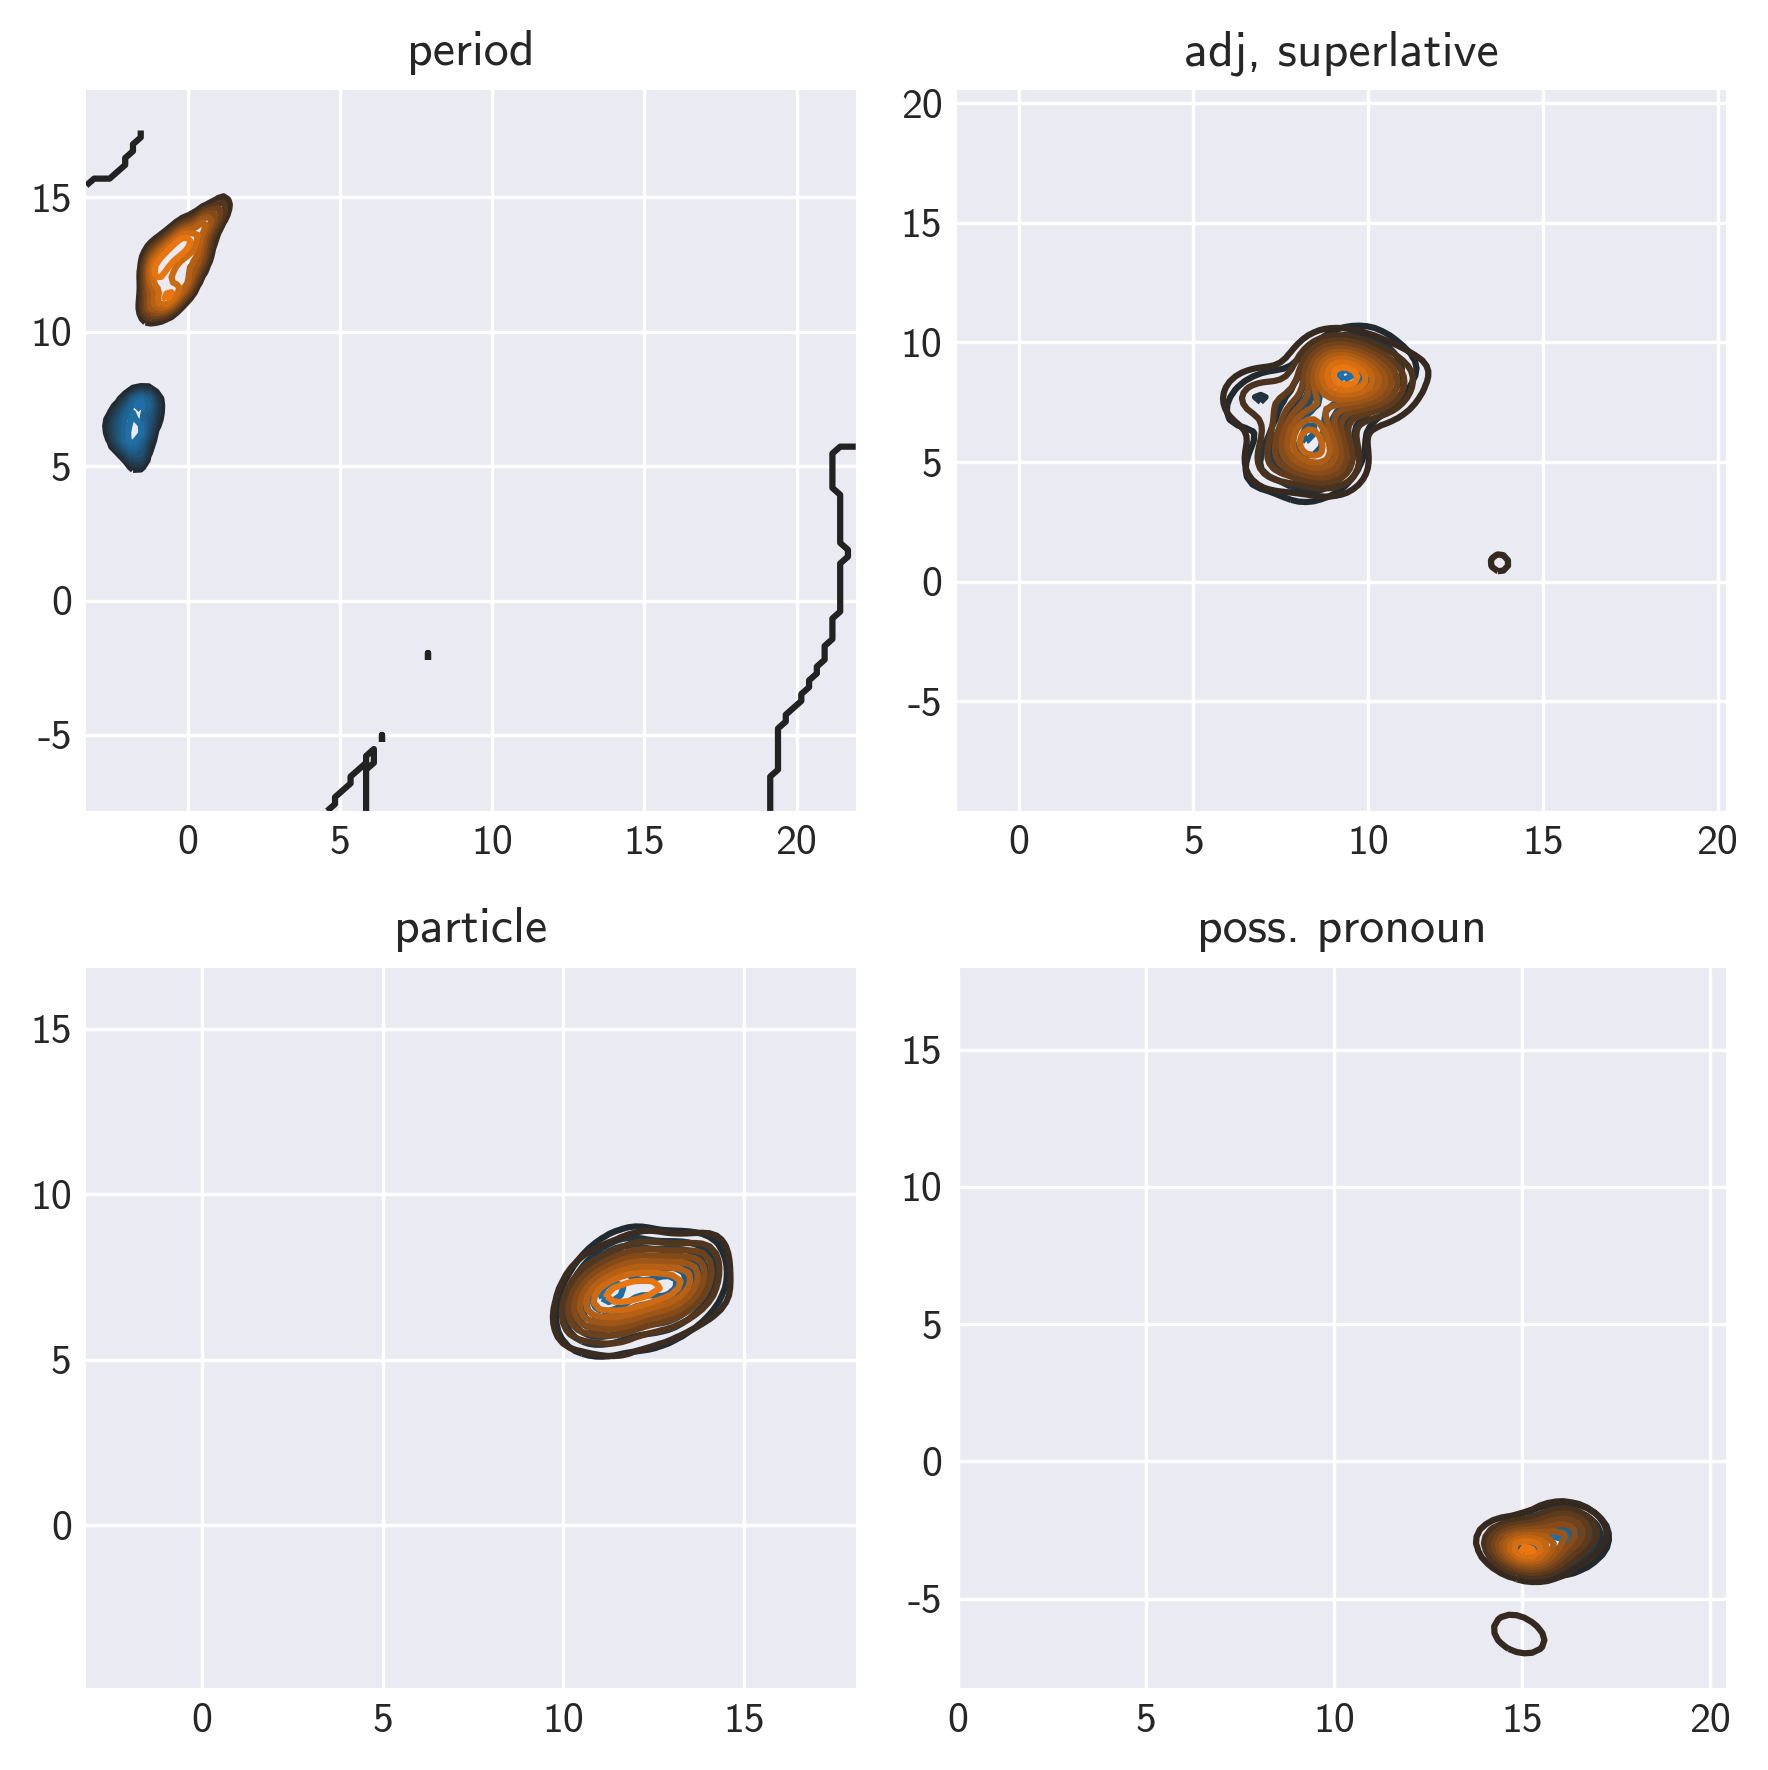

CPU times: user 1min 45s, sys: 2.37 s, total: 1min 47s
Wall time: 26.6 s


In [240]:
%%time
titles = ['period', 'adj, superlative', 'particle', 'poss. pronoun']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), dpi=300)
axs = np.array(axs).flatten()
i = 0
for (grp, indices) in tag_index_sets.items():
    count = len(indices)
    print(f'{grp}, n_tokens = {count}')
    point_labels = ['dense']*count + ['sparse']*count
    indices_of_interest = indices + [idx + total_tokens for idx in indices]
    
    reps_subset = reps_pca[indices_of_interest]
    emb = umap.transform(reps_subset)
    
    sns.kdeplot(emb[:, 0][:count], emb[:, 1][:count], ax=axs[i])
    sns.kdeplot(emb[:, 0][count:], emb[:, 1][count:], ax=axs[i])
    axs[i].set_title(titles[i])
    i += 1
plt.tight_layout()
# plt.savefig('/raj-learn/lth-fairseq/analysis/figures/POS_UMAP.png')
plt.show()

., n_tokens = 7654
JJS, n_tokens = 364
RP, n_tokens = 522
PRP$, n_tokens = 1603


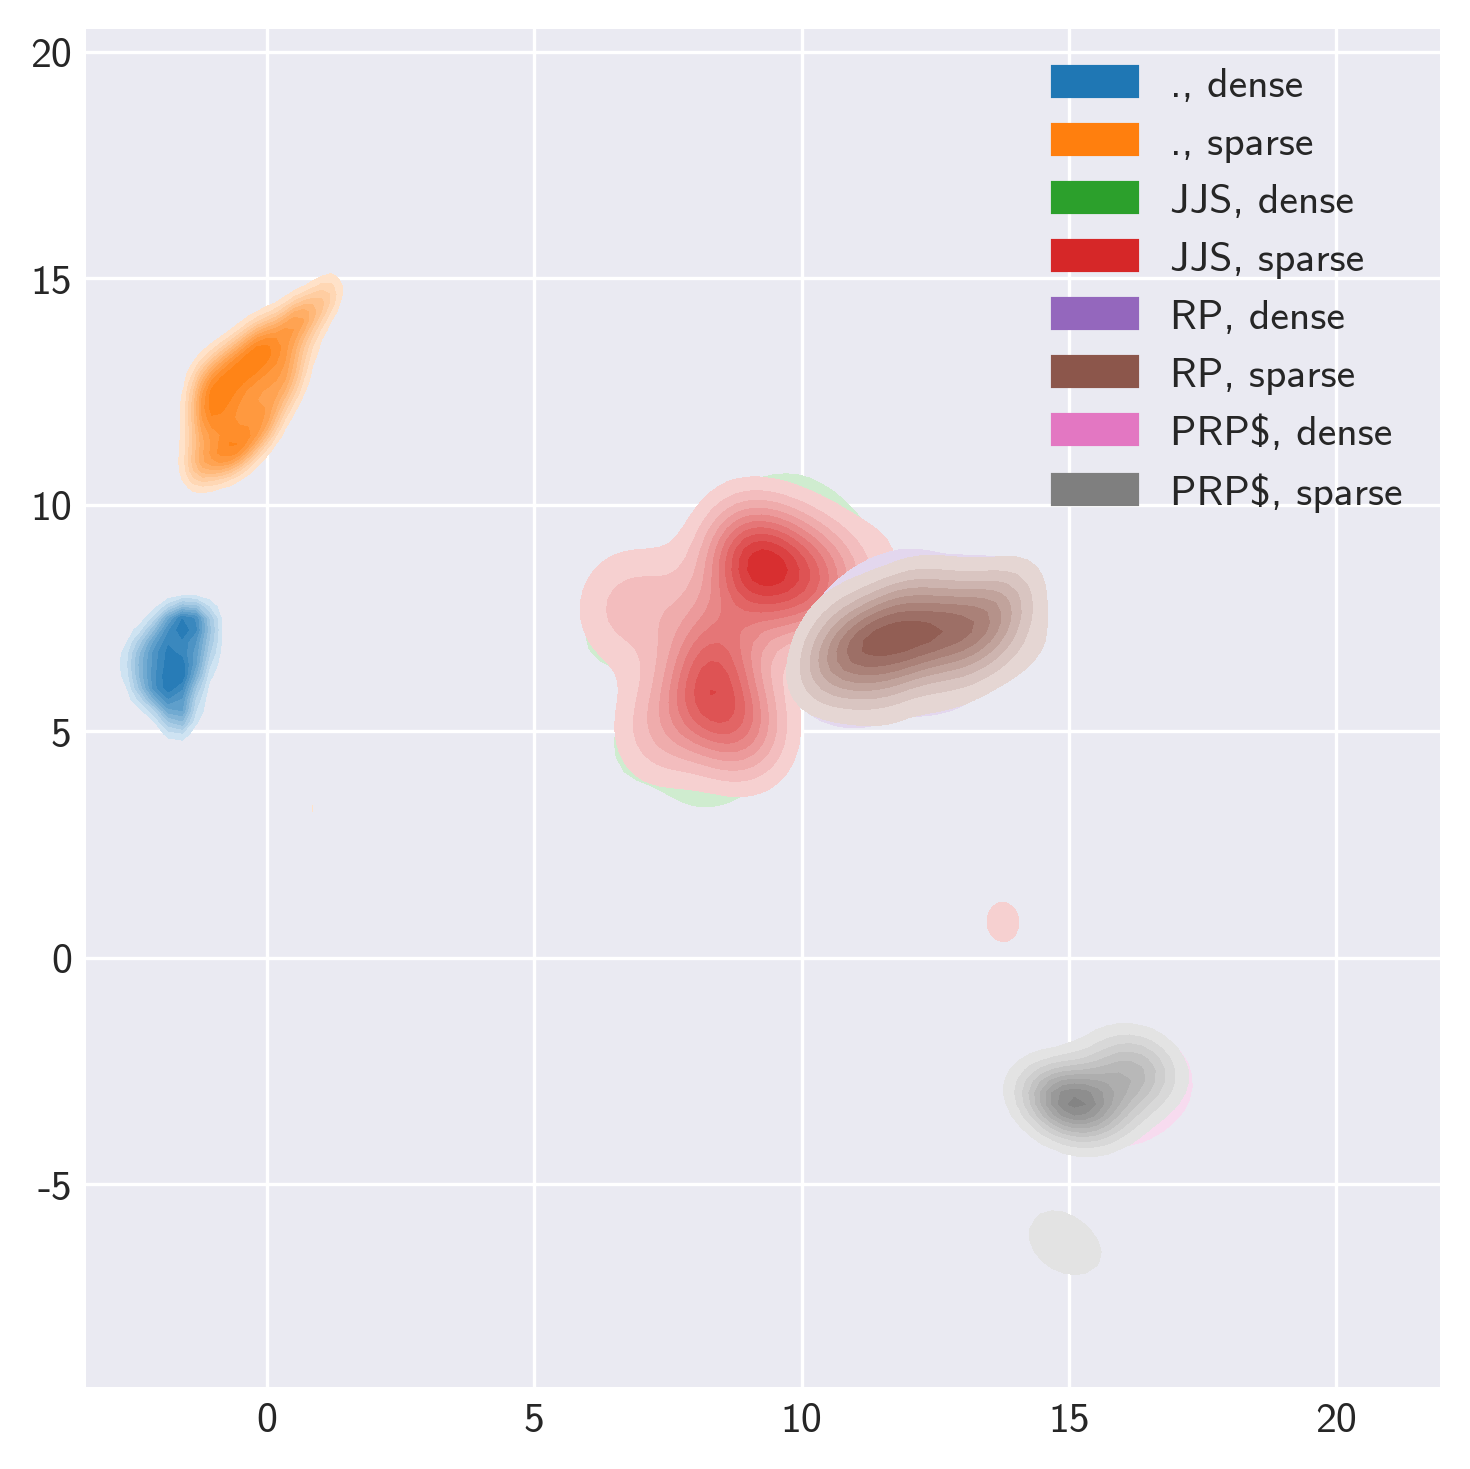

CPU times: user 1min 28s, sys: 1.41 s, total: 1min 29s
Wall time: 22.9 s


In [243]:
%%time
titles = ['period', 'adj, superlative', 'particle', 'poss. pronoun']
plt.figure(figsize=(5,5), dpi=300)
ax=plt.gca()
i = 0
for (grp, indices) in tag_index_sets.items():
    count = len(indices)
    print(f'{grp}, n_tokens = {count}')
    indices_of_interest = indices + [idx + total_tokens for idx in indices]
    
    reps_subset = reps_pca[indices_of_interest]
    emb = umap.transform(reps_subset)
    
    sns.kdeplot(emb[:, 0][:count], emb[:, 1][:count], ax=ax, label=f'{grp}, dense', shade=True, shade_lowest=False)
    sns.kdeplot(emb[:, 0][count:], emb[:, 1][count:], ax=ax, label=f'{grp}, sparse', shade=True, shade_lowest=False)
    i += 1
plt.legend()
plt.tight_layout()
# plt.savefig('/raj-learn/lth-fairseq/analysis/figures/POS_UMAP.png')
plt.show()